# Optiver Realized Volatility Prediction
データサイエンスのスキルを応用して、金融市場を改善します

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
! jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [10]:
! jt -t monokai

# 1. 何を予測するか(submission.csvから見ます)

In [14]:
sample = pd.read_csv("./input_data/sample_submission.csv")
sample

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


### row_idとtargetしかありません。
### targetはボラティリティ(価格変動の度合い)でそれを予測するコンペなのだと思います。
### row_idとは何かは次を参照。

# 2. 何から予測するか(test.csvから見ます)

In [16]:
test = pd.read_csv("./input_data/test.csv")
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


#### submissionファイルのrow_idはstock_id(株のid)とtime_id(時間のid)を-でつなげたものということがわかる。


#### さらにtest.csvには、book_test.parquetとtrade_test.parquetというものがついています。今回はstock_id = 0のものだけ。中身を見てみる
※　ファイルパスでも開くけど、その上のフォルダまでのpathで開くみたいです。

In [19]:
book_testparquet = pd.read_parquet("./input_data/book_test.parquet/stock_id=0")
book_testparquet

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


In [20]:
trade_testparquet = pd.read_parquet("./input_data/trade_test.parquet/stock_id=0")
trade_testparquet

,time_id,seconds_in_bucket,price,size,order_count
0,4,7,1.000344,1,1
1,4,24,1.000049,100,7
2,4,27,1.000059,100,3


#### これらの情報から、株のボラティリティ(価格変動の度合い)を当てるコンペだと思います。
#### 以上を踏まえて、各項目の解説を含めてtrain.csvを見ていき,EDAしてお試しでsubmitしていきます。

# 3. train.csv

In [21]:
train = pd.read_csv("./input_data/train.csv")
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


#### とても単純な構成。株のstock_idとtime_id、targetの値が出ています。
#### targetはDataに解説あるように、10分間のtotalボラティリティだと思います（これを学習のtargetとします。）

# 4. train.parquet

#### testデータでの解説と同様に、train.csvに付随したファイルとして、book_train.parquetとtrade_train.parquetいうファイルがついています。
#### 例えばtrain.csvの一番上の株の銘柄 stock_id=0のそれぞれのparquetファイルを見てみます。

## **4.1 book_train.parquet**


#### 市場に投入された最も競争力のある売買注文に関するオーダーブックデータを提供します。
#### bookの上位2つのレベルが共有されます。bookの第1レベルは価格面でより競争力があり、第2レベルよりも実行が優先されます。


******補足(個人的解釈)******

オーダーbookデータは予約状況だと思います。この値段まで下がってきたら、買う。上がってきたら売るみたいな予約情報です。

In [22]:
book_example = pd.read_parquet('./input_data/book_train.parquet/stock_id=0')
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


Bid（売値） は、買い手が株を買う上で希望する価格で、Ask（買値）は、売り手が株を売る上で希望する価格です。
わかりやすく言い換えると、

* stock_id : 株の銘柄（どの株か）
* time_id : どの時間の情報かのid (submissionファイルのtime_idと連動しています)
* seconds_in_bucket : time_idの中で、0からスタートして何秒後か。たぶん予測するのは、10分のtotalなので、seconds_in_bucketは、最大600 secのはず
* bid_price1,2 : 株の買値の希望値の１番目と２番目
※　(Normalized prices of the most/second most competitive buy level. だから、正確には、１番と２番目に正規化されたレベルの買値。

→買値の希望値をみんな出しているけど、それの正規化したときに一番多い値と２番目に多い値と推測。以下askも逆の現象。)


* ask_price1,2 : 株の売り値の希望値
* bid_size1,2 : 買うのを希望している側の１番目と２番目の株式数
* ask_size1,2 : 売るのを希望している側の１番目と２番目の株式数


※　parquetはロード時にカテゴリデータ型に強制することに注意が必要らしいです。


## 4.2 **trade_train.parquet**

#### 実際に実行された取引に関するデータが含まれています。
#### 通常、市場では、実際の取引よりも受動的な売買意図の更新（bookの更新）が多いため、このファイルは注文書よりもまばらであると予想される場合があります。

******補足(個人的解釈)******

リアルタイムで実際に取引された量。買い手がこの値段でこの数量買い、売り手がこの値段でこの数量売ったと推測。

In [23]:
trade_example = pd.read_parquet("./input_data/trade_train.parquet/stock_id=0")
trade_example

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


* stock_id - 同上。
* time_id - 同上。
* seconds_in_bucket- 同上。トレードデータとブックデータは同じ時間枠から取得され、トレードデータは一般にまばらであるため、このフィールドは必ずしも0から始まるとは限らないことに注意してください。
* price-1秒間に発生する実行済みトランザクションの平均価格。価格は正規化されており、平均は各トランザクションで取引された株式数によって重み付けされています。
* size -取引された株式の総数。
* order_count -発生している固有の取引注文の数。

#### 一番上に示したtestデータもtrainデータと同じ構造です。testデータには、targetだけないので、それを予測します。

# 5. EDA

## 5.1 株式ごとの解析
### 5.1.1 株の数

In [24]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [25]:
for col in train.columns:
    print(col,":",len(train[col].unique()))

stock_id : 112
time_id : 3830
target : 414287


## stock_id(株の銘柄) は112種類、time_idは3830種類、targetは414287種類ある

## 5.1.2 株ごとの統計量

In [26]:
stock = train.groupby("stock_id")["target"].agg(["mean","median","std","count","sum"]).reset_index()
stock

,stock_id,mean,median,std,count,sum
0,0,0.004028,0.003180,0.002855,3830,15.429071
1,1,0.004362,0.003719,0.002433,3830,16.704962
2,2,0.002385,0.001748,0.002339,3830,9.133223
3,3,0.006182,0.005422,0.003201,3830,23.675414
4,4,0.004197,0.003397,0.002879,3830,16.073408
...,...,...,...,...,...,...
107,122,0.003762,0.003176,0.002300,3830,14.407997
108,123,0.002506,0.001967,0.001816,3830,9.599594
109,124,0.003691,0.003143,0.001953,3830,14.135579
110,125,0.002016,0.001575,0.001703,3830,7.719409


#### mean値とsumだけヒストグラム見てみます。

mean value= 0.0038805243039130312


(array([ 5., 25., 25., 22., 18.,  8.,  3.,  4.,  1.,  1.]),
 array([0.00147492, 0.00219811, 0.0029213 , 0.00364449, 0.00436768,
        0.00509087, 0.00581406, 0.00653724, 0.00726043, 0.00798362,
        0.00870681]),
 <BarContainer object of 10 artists>)

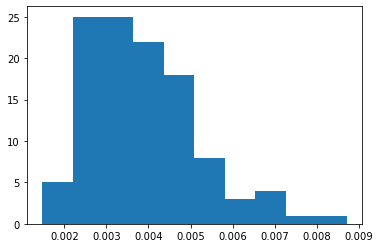

In [27]:
print("mean value=" ,stock["mean"].mean())
plt.hist(stock["mean"])

## 平均値は0.003とほぼ0に近い

sum value= 14.860998424142867


(array([ 5., 25., 25., 22., 18.,  8.,  3.,  4.,  1.,  1.]),
 array([ 5.64894774,  8.4187619 , 11.18857607, 13.95839023, 16.72820439,
        19.49801856, 22.26783272, 25.03764689, 27.80746105, 30.57727522,
        33.34708938]),
 <BarContainer object of 10 artists>)

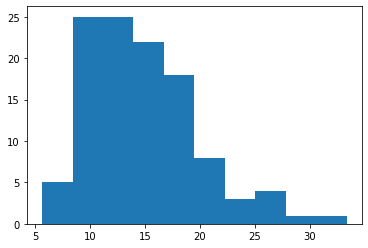

In [28]:
print("sum value=" ,stock["sum"].mean())
plt.hist(stock["sum"])

## この期間のtotalボラティリティは、平均14.8, maxだと30を超える銘柄も存在。

--------------以下、stock id = 0のtime_id = 5の10分間のふるまいを見ていきます -------------

## 5.2 time_id内でのBid,Ask,実際の取引のふるまい価格の関係

In [29]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [30]:
book_test = book_example[book_example["time_id"]==5]
book_test

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3


## 5.2.1 価格変動 (個別 + 全体を重ねたもの)

#### まずは、オーダーブック情報

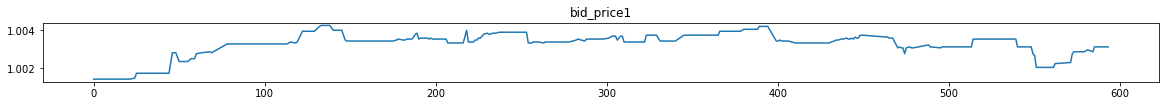

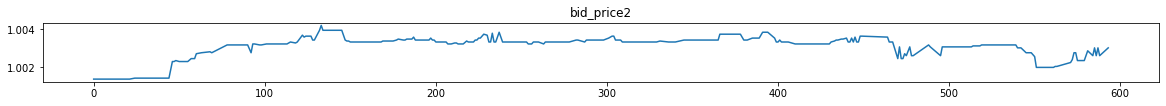

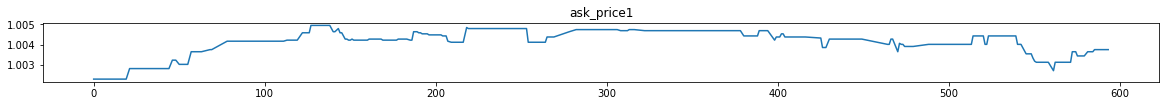

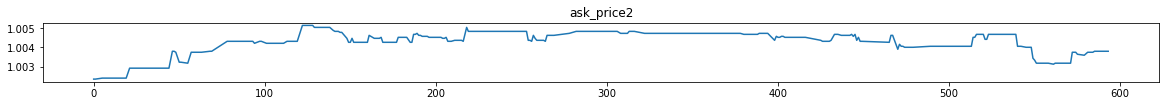

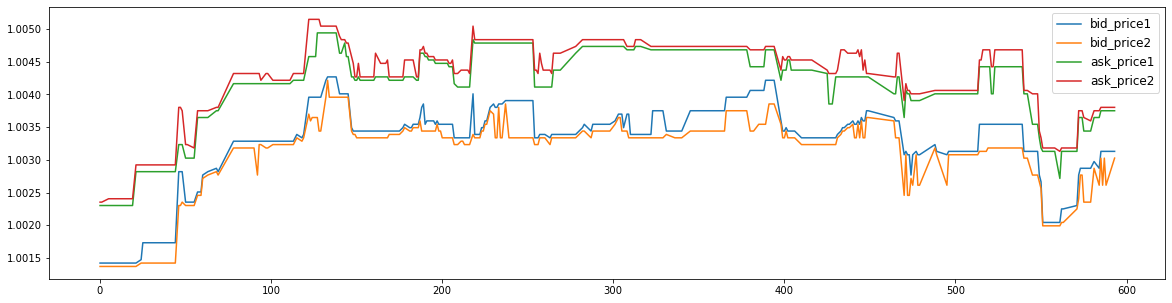

In [31]:
samples = ["bid_price1","bid_price2","ask_price1","ask_price2"]

for num,a in enumerate(samples):
    plt.figure(figsize=(20,5))
   
    plt.subplot(4,1,num+1)
    plt.plot(book_test["seconds_in_bucket"],book_test[a])
    plt.title(a)
plt.show()
plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    
   
    plt.plot(book_test["seconds_in_bucket"],book_test[a],label=a)
plt.legend(fontsize=12)


#### これに実際の取引情報を追記します。

In [32]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


In [33]:
trade_test = trade_example[trade_example["time_id"]==5]
trade_test.head(5)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


#### 全体のグラフに、実際の取引を加えてみる

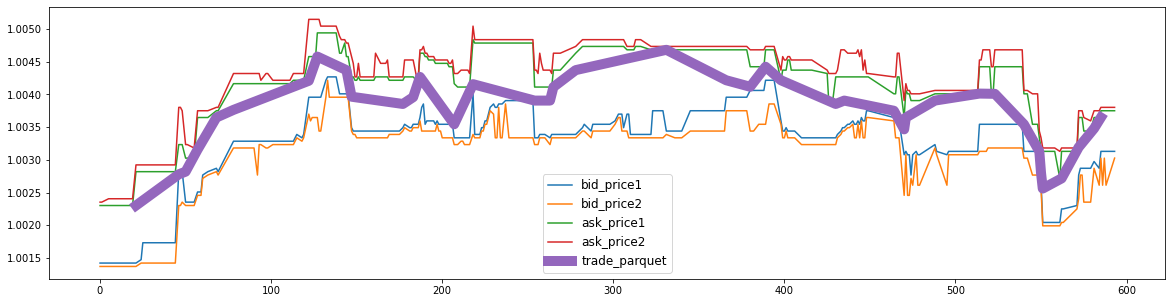

In [34]:
plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    
   
    plt.plot(book_test["seconds_in_bucket"],book_test[a],label=a)
    
plt.plot(trade_test["seconds_in_bucket"],trade_test["price"],label="trade_parquet",lw=10)
plt.legend(fontsize=12)

## 紫が実際の取引。オーダーブックのbidとaskの間をうろうろしている。

#### ※bitやaskのところ近づいたら、攻防があって、超えたらブレイクしてなどその辺は専門家に任せます。

#### time id5の10分間の中でも、bidとaskの値は変動していることがわかる。これのばらつきが大きいとボラティリティと関係するかもしれない。
#### 例えば、急に株価を変動するニュースが入った時に、ボラティリティがボーンと上がって、
#### 乱高下するとばらつきとかが増えるのかもと推測。Max-Minとかも重要かも。(ボラティリティを予測するから逆の発想ですね)

## 5.2.2 ボラティリティのイメージ

stock_id = 0で最もボラティリティが低かった時をグラフにしてみます。

In [35]:
stock0 = train[train["stock_id"]==0]
min_index = stock0["target"].idxmin()
min_time_id = stock0.iloc[min_index]["time_id"]
print("min index is",min_time_id,"min target is",stock0.iloc[min_index]["target"])

min index is 24253.0 min target is 0.000593833


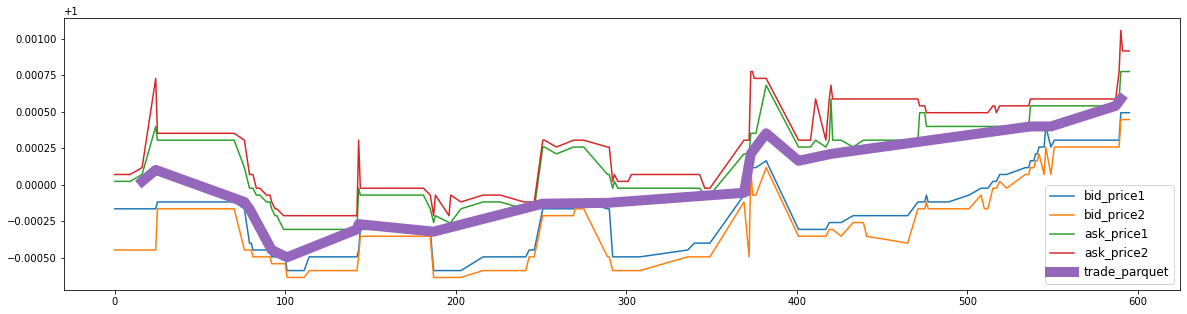

In [36]:
book_test_min = book_example[book_example["time_id"]==min_time_id]
trade_test_min = trade_example[trade_example["time_id"]==min_time_id]


plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    
   
    plt.plot(book_test_min["seconds_in_bucket"],book_test_min[a],label=a)
    
plt.plot(trade_test_min["seconds_in_bucket"],trade_test_min["price"],label="trade_parquet",lw=10)
plt.legend(fontsize=12)

stock_id = 0で最もボラティリティが高かった時をグラフにしてみます。

In [37]:
stock0 = train[train["stock_id"]==0]
max_index = stock0["target"].idxmax()
max_time_id = stock0.iloc[max_index]["time_id"]
print("max index is",max_time_id,"max target is",stock0.iloc[max_index]["target"])

max index is 19725.0 max target is 0.036311154


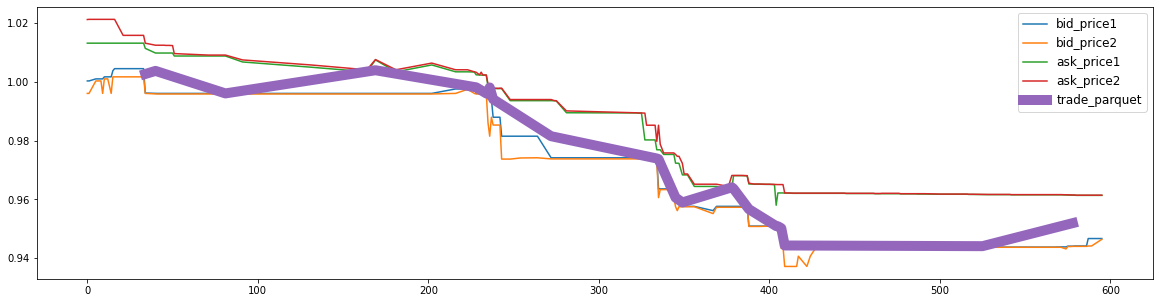

In [38]:
book_test_max = book_example[book_example["time_id"]==max_time_id]
trade_test_max = trade_example[trade_example["time_id"]==max_time_id]


plt.figure(figsize=(20,5))

for num,a in enumerate(samples):
    
   
    plt.plot(book_test_max["seconds_in_bucket"],book_test_max[a],label=a)
    
plt.plot(trade_test_max["seconds_in_bucket"],trade_test_max["price"],label="trade_parquet",lw=10)
plt.legend(fontsize=12)

#### 縦軸のスケールが全然違うので、実際の取引を重ねてみます。

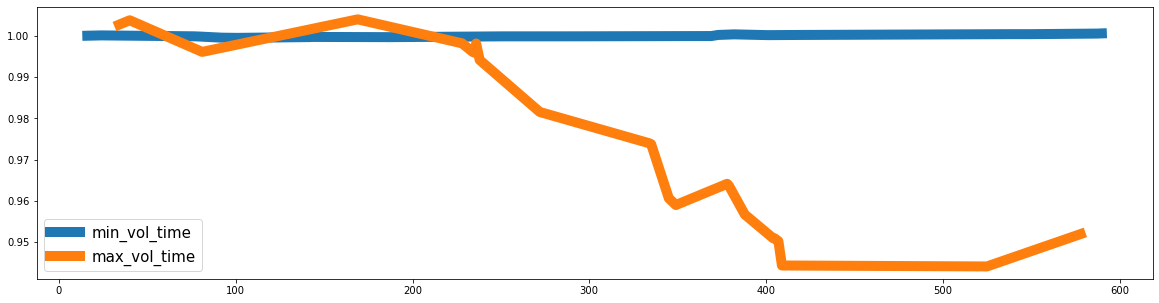

In [39]:
plt.figure(figsize=(20,5))
plt.plot(trade_test_min["seconds_in_bucket"],trade_test_min["price"],lw=10,label="min_vol_time")
plt.plot(trade_test_max["seconds_in_bucket"],trade_test_max["price"],lw=10,label = "max_vol_time")
plt.legend(fontsize=15)

## ボラティリティが高いときはこの場合は、10分間でかなりの価格変動を起こしていることがわかる。
#### (ばらつきや、Max-Minはやっぱり大事そう)

# 6.submit

## お試しで株ごとのmedian値を全部入れてsubmitします

## 6.1 株ごとのmedian値のdictionary作成

In [40]:
stock

,stock_id,mean,median,std,count,sum
0,0,0.004028,0.003180,0.002855,3830,15.429071
1,1,0.004362,0.003719,0.002433,3830,16.704962
2,2,0.002385,0.001748,0.002339,3830,9.133223
3,3,0.006182,0.005422,0.003201,3830,23.675414
4,4,0.004197,0.003397,0.002879,3830,16.073408
...,...,...,...,...,...,...
107,122,0.003762,0.003176,0.002300,3830,14.407997
108,123,0.002506,0.001967,0.001816,3830,9.599594
109,124,0.003691,0.003143,0.001953,3830,14.135579
110,125,0.002016,0.001575,0.001703,3830,7.719409


In [41]:
stock2 = stock[["stock_id","median"]]
stock2 = stock2.set_index("stock_id")
stock2

,median
stock_id,
0,0.003180
1,0.003719
2,0.001748
3,0.005422
4,0.003397
...,...
122,0.003176
123,0.001967
124,0.003143


In [42]:
stock_dict = stock2.to_dict()
# example stock id = 0のmedian値
stock_dict["median"][0]

0.00317963

## 6.2 submitファイルの置き換えとsubmission fileの生成

In [43]:
sample # sample_submission.csvです

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


row_idからstock_id抽出

In [44]:
sample["stock_id"] = [s.split("-")[0] for s in sample["row_id"]]
sample

,row_id,target,stock_id
0,0-4,0.003048,0
1,0-32,0.003048,0
2,0-34,0.003048,0


辞書型の中身を代入

In [45]:
sample["target"] = [stock_dict["median"][int(s)] for s in sample["stock_id"]]
sample

,row_id,target,stock_id
0,0-4,0.00318,0
1,0-32,0.00318,0
2,0-34,0.00318,0


stock_id削除

In [46]:
sample = sample.drop("stock_id",axis=1)
sample

,row_id,target
0,0-4,0.00318
1,0-32,0.00318
2,0-34,0.00318


In [47]:
sample.to_csv("submission.csv",index=False)